1 window = 1 prediction <br>
1 timestep = 1ne Nummer, bei einer windowSize von 7 gibt es 7 timesteps, nach diesen 7 timesteps kommt eine prediction <br>
1 timestep = eine Veränderung des Cell_state <br>
Anzahl timesteps entspricht windowsSize <br>
1 batch = 1 Anpassung aller Gewichte (lstm celle und output layer), da nicht als nicht-trainierbar erzeugt(die variablen)

normalisieren = original-werte skalieren zum Beispeil von [+inf,-inf] to [0,1] <br><br>
logits = nicht normalisierte Prediction(also nicht zwischen irgendwelchen festen Werten wie 0 und 1), also Prediction die outputLayer zum Beispiel auswirft; Logits werden im Folgeschritt als Input der Softmax o.ä. genommen (name logits impliziert, dass werte anschließend in aktivierungsfunktion kommen) <br>
-> bei uns meist trotzdem im Bereich [-1,1] da Input per MinMaxScaler skaliert wurde, bei uns wird im Anschluss aber auch keine Aktivierungsfunktion durchlaufen<br><br>
lsltm-stateisTupel=Yes: LSTM hat cell state and output, cell state behält lstm cell für sich, output wird geoutputtet -> beides aber brauch lstm cell für nächsten time step, deshalb Tupel, eben von (cellstate,output) <br>


In [571]:
import numpy as np
import tensorflow as tf
import pandas as pd
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from numpy import array
import datetime


## Step 0. Loading dataset

In [572]:
tesla_stocks = pd.read_csv('AdidasAG10Years.csv')


In [573]:
tesla_stocks.head()

,date,close,volume,open,high,low
0,16:00,104.760,"57,787",NaN,105.5700,104.5200
1,2017/12/01,104.595,79476.0000,104.25,104.9999,104.0000
2,2017/11/30,104.440,54341.0000,105.35,105.4840,104.2500
3,2017/11/29,104.920,106076.0000,107.21,107.3500,104.9200
4,2017/11/28,106.285,62220.0000,106.65,106.6500,105.9754


In [574]:
data_to_use = tesla_stocks['close'].values
data_to_use = np.flipud(data_to_use) # flips values to get the newest values to the end

In [575]:
print('Total number of days in the dataset: {}'.format(len(data_to_use)))

Total number of days in the dataset: 2522


## Step 1. Data preprocessing <br>
#### Input :     INPUT -> lstm -> outputlayer -> mse(bptt)

#### Step 1.1 Scaling data mit Standart-Scaler

In [576]:
scaler = MinMaxScaler(feature_range=(-2,2)) # mapped alle Werte auf [-1;1] aufgrund von eventuell sehr hohen Werten -> squard error


#### Data vor der Skalierung

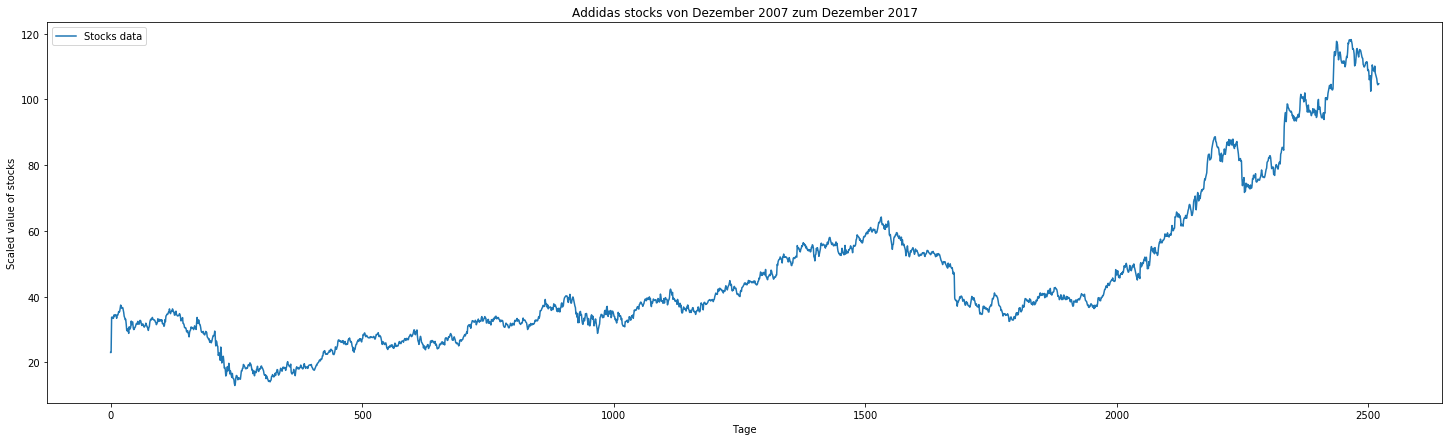

In [577]:
plt.figure(figsize=(25,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Addidas stocks von Dezember 2007 zum Dezember 2017')
plt.xlabel('Tage')
plt.ylabel('Scaled value of stocks')
plt.plot(data_to_use, label='Stocks data')
plt.legend()
plt.show()

In [578]:
reshaped_dataset = data_to_use.reshape(-1,1) #why? cause 1 feature
   #reshape(3,4,2)
   #reshape = Form des Array umformen ohne Daten zu ändern, lesen wie umformen into reshape([3],[4],[2])
   #-1 = anpassung dieser Dimension an die anderen, die man reshape gibt
   #reshape(-1,1) bedeuted also das man irgendwie [unbekannt][1] haben will, wobei sich unbekannt eben aus
   #[1] und der Gesamtzahl ableiten lässt
scaler = scaler.fit(reshaped_dataset)
scaled_dataset = scaler.transform(reshaped_dataset)

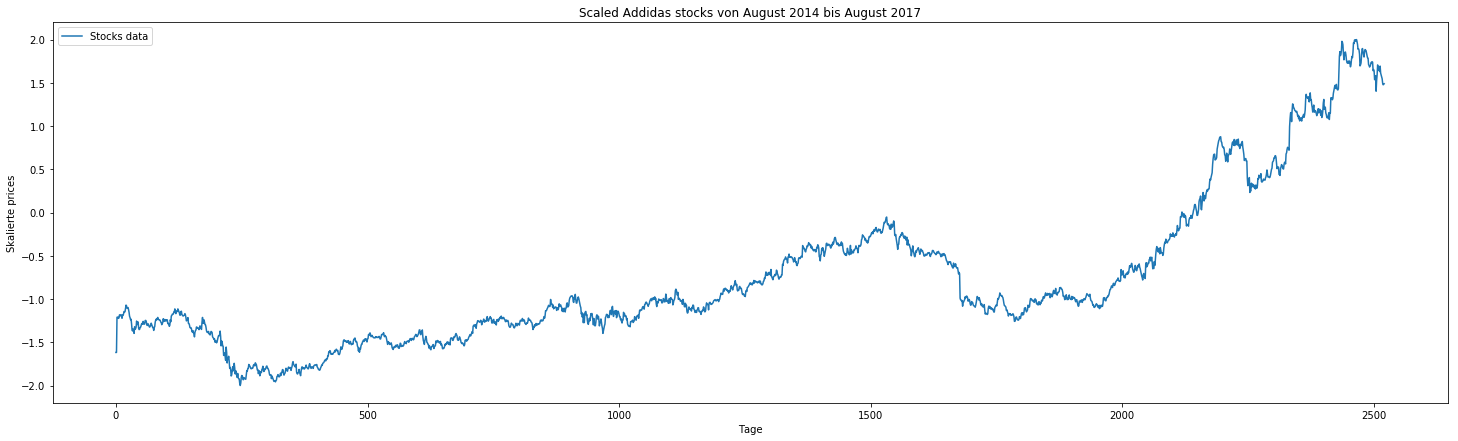

In [579]:
plt.figure(figsize=(25,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled Addidas stocks von August 2014 bis August 2017')
plt.xlabel('Tage')
plt.ylabel('Skalierte prices')
plt.plot(scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

In [580]:
window_size_all = 7 #muss durch 7 teilbar sein
batch_size = 9
epochs = 20 #eig 3
train_range = 704 #muss durch batch_size teil-bar sein
train_p = 0.666
dropout=0.2
number_of_layers= 3
learning_rate=0.0001
hidden_layer_size=512
future_is_now = 100
logs_path= 'logs/'

###### windows data <br>
values 1-7 in einem window <br >
der 7. value wird zusätzlich in eben y gespeichert (=Label)

In [581]:
def window_data(data, window_size, future_is_now): #Taktik: speichere eine Liste von Werten der Datensätze von x bis x+ windowssize, danach speichere eine Liste von Werten der Datensätze von x+1 bis x+1+windowssize, damit man
                                    #praktisch immer nach 1 Windows eine Prediction machen kann
    X = []
    y = []
    
    i = 0
    for i in range(0, len(data) - window_size - future_is_now, future_is_now):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+future_is_now-1])
    assert len(X) ==  len(y)
    return X, y

#### Step 1.2 Windowing the dataset

In [582]:
X, y = window_data(scaled_dataset, window_size_all, future_is_now) #mn
#X, y = window_data(reshaped_dataset, window_size_all)

#### Step 1.3 Creating Training and Testing sets
trainingsdaten: 0-700 <br>
testDaten 700-X <br> <br>
Theorie: 2/3: Training, 1/3 Test

In [583]:
train_max = int(len(X) * train_p)
X_train  = np.array(X[:train_max])
y_train = np.array(y[:train_max])

for i in range(batch_size, 1, -1):
    if train_max % i == 0:
        batch_size = i
        break

print(batch_size)

X_test = np.array(X[train_max:])
y_test = np.array(y[train_max:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

8
X_train size: (16, 7, 1)
y_train size: (16, 1)
X_test size: (9, 7, 1)
y_test size: (9, 1)


## Step 2. RNN - LSTM - Netzwerk definieren -> (Funktionen und Objekte definieren)

#### Hidden Layer :     input -> LSTM -> outputlayer -> mse(bptt) <br>
 Erstellung einer Zelle (komplettes Hiddenlayer)

In [584]:
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers,dropout_rate, dropout=True):
    
    #layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    
    
   
    #layer_list = [layer]*number_of_layers
    layer_list = []
    for counter in range(number_of_layers):
        layer = tf.nn.rnn_cell.BasicLSTMCell(hidden_layer_size)
        if dropout:
            layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        layer_list.append(layer)
        

        
    cell = tf.contrib.rnn.MultiRNNCell(layer_list) # multi-RNN stacked Basic Cell übereinander: basiccell1 -> basiccell2 -> bc3 -> ... -> output
    #warum diese Syntax -> [layer] * number_of_layers ? Weil eine Liste von BasicLSTMCell -en gebraucht wird und durch Python-Syntax wird dadurch number_of_hiddenlayers oft ein layer hier aka BasicLSTMCell erstellt
    
    init_state = cell.zero_state(batch_size, tf.float32) #zero_state -> alle values to 0
    print(type(init_state),"n",init_state)
    return cell, init_state

#### Output Layer :     Input -> LSTM -> OUTPUTLAYER -> mse(bptt)

In [585]:
def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :] #es interessiert nur der letzte output... -1 d.h. in python letztes element, [batch_size][timesteps][features] -> [batch_size][hiddenlayer_size]
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    with tf.name_scope('Output_OutputLayer'):
        output = tf.matmul(x, weights) + bias #result: 7x1 ! # warum matmul und nicht skalar-wise                                                                                                     -> scalar -wise nur bei normalen rnn, da man selbe matrizen mit einander multipliziert oder eben bei multidim. NN wenn jedes Layer die selbe Form hat dann auch irgendwie glaube
                                          #hier: 7x1 * 1x1   
                                            #warum keine Aktivierungsfunktion ? -> wir rechnen keine Wahrscheinlichkeiten aus sondern direkt die Preis-Werte
    
    return output #7x1 -> es folgen also Anzahl der batches * 7x1 Predictions | anders | Anzahl batches * batchSize * 1 Predictions, da pro Windows 1 Prediction kommt und batch Size sagt, wie viele Window in 1 batch kommen

###### gradient clipping  <br>
gradienten clipping = man beschränkt den exploding gradient auf eine max Zahl, sodass er nicht über diese max Zahl (Limit) gehen kann <br>
clipping hilft gegen exploding gradient, siehe standford folie 11: 46, code ist fast der selbe  <br>
eigentlich nur bei rekurrenten neuronalen Netzen -> <b> lstm gegen vanishing and clipping gegen exploding <b>

In [586]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))]) #mse
        
        
        ####
        #hier müsste eigentlich accuracy berechnet werden, eben wie auch loss -> gucken nach tensorflow define loss and accuracy
        #nein doch nicht, da accuarcy ja nicht nur bezüglich unserer richtigen Predictions berechnet wird, hier wird ja 
        ###
        
        
    with tf.name_scope('Loss'):    
        loss = tf.reduce_sum(losses)/(2*batch_size)
    #Cliping the gradient loss
    
    gradients = tf.gradients(loss, tf.trainable_variables(),name="gradientsCalculated")
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin,name="ClipperIsSetTo4")
    optimizer = tf.train.AdamOptimizer(learning_rate,name="AdamOptimizer")
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()),name="applyGradientsForOptimisation") #zip: a = [a1,a2]; b=[b1,b2] zip(a,b) = [(a1,b1),(a2,b2)]
    return loss, train_optimizer

#### RNN - Object: <br/> <br/> 
Hiddenlayer=1, hidden_layer_size=512, learning_rate=0.001, dropout=80%, window size=7, batch_size=7, 

In [587]:
class StockPredictionRNN(object):
    
    def __init__(self, dropout_rate,learning_rate=0.001, batch_size=7, hidden_layer_size=512, number_of_layers=2, 
                 dropout=True, number_of_classes=1, gradient_clip_margin=4, window_size=7):
    
        self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        
        self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')
        
        

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)
        
        outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)
        #outputs = tf.Print(outputs,[outputs, tf.shape(outputs)], message="value of output:" )
    
        
        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes) # logits = die wirklichen Predictions des netzwerkes im Format [batchNummer][AnzahlPredictions] wobei hier: [7][1]  
        
        with tf.name_scope('lossScope'):
            self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin)
            tf.summary.scalar("loss1", self.loss)
            
        
        with tf.name_scope('accuracyScope'):
           
            self.correct_prediction = tf.equal(tf.argmax(self.logits,1),tf.argmax(self.targets,1),name="TensorOfCorrectPredictions")
            #self.correct_prediction = tf.equal((self.logits),(self.targets),name="TensorOfCorrectPredictions")
            
            print("logitsShape",self.logits.shape)
            print("logitsShape",self.targets.shape)
            #self.arg1 = tf.argmax(self.logits,1)
            #self.arg2= tf.argmax(self.targets,1) liefert trotz gleicher funktion verschieden-artige Ergebnisse -> 1. liefert eben den index, 2. liefert ganz normal 7x1 Ausgabe
           # list_args =[self.arg1,self.arg2]
           # self.targetsGucekn = self.targets
            
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
            tf.summary.scalar("accuracy", self.accuracy)
        
        self.merged_summary_op = tf.summary.merge_all()
       # self.accuracy,_ = tf.metrics.accuracy(labels=tf.argmax(self.targets, 1,name="MaxIndexSearchTargets"), predictions=tf.argmax(self.logits,1,name="MaxIndexSearchLogits"),name="Accuracy")

## Step 3. RNN - LSTM - Netzwerk erstellen -> (Model als Objekt erstellen)

In [588]:
tf.reset_default_graph()
model = StockPredictionRNN(batch_size=batch_size, dropout_rate=dropout, window_size=window_size_all,number_of_layers = number_of_layers,learning_rate=learning_rate, hidden_layer_size=hidden_layer_size)

<class 'tuple'> n (LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros:0' shape=(8, 512) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState/BasicLSTMCellZeroState/zeros_1:0' shape=(8, 512) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState_1/BasicLSTMCellZeroState/zeros:0' shape=(8, 512) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState_1/BasicLSTMCellZeroState/zeros_1:0' shape=(8, 512) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState_2/BasicLSTMCellZeroState/zeros:0' shape=(8, 512) dtype=float32>, h=<tf.Tensor 'MultiRNNCellZeroState/DropoutWrapperZeroState_2/BasicLSTMCellZeroState/zeros_1:0' shape=(8, 512) dtype=float32>))
logitsShape (8, 1)
logitsShape (8, 1)


## Step 4. Netzwerk trainieren

In [589]:
session =  tf.Session()

In [590]:
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())


In [591]:
epoch_loss = []
accuracy = 0.0


tf.summary.scalar("accuracy", accuracy)

summary_writer = tf.summary.FileWriter(logs_path,session.graph)

total_batch = 0

for i in range(epochs):
    traind_scores = []
    ii = 0
    
    while(ii + batch_size) <= len(X_train): #ein Durchlauf = 1 batch = 1 BPTT = 1 Anpassung der Gewichte = 1x "Lernen"
        total_batch+=1                          #Anzahl Durchläufe = Anzahl der Batch-es insgesamt = nicht direkt spezifiziert, indirekt festgelegt durch , wann reichen die vorhandenen Daten nicht mehr(siehe Schleifenbedingung)
        X_batch = X_train[ii:ii+batch_size]
        
        y_batch = y_train[ii:ii+batch_size]
        o, c, _,summary = session.run([model.logits,model.loss, model.opt,model.merged_summary_op], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        #print("Logits", o)
        #print("targets", y_batch)
        
        #print("Arg1",arg1)
        #print("Arg2",arg2)
        #print("correct_pre", correct_pre)
        #print("Accuracy", accuracy)
        
        #o=model.logits=logits 7x1 bzw [batchSize][Prediction] -> windowsSize wurde herausgestrichen, da pro windows Size ehh immer 1 prediction war -> windowSize kann raus
        #c=model.loss=loss
        #_=model.opt=für Weiteres unbenutzt = train_optimizer        

        summary_writer.add_summary(summary, i * total_batch+ii)     
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    if (i % 1) == 0:
        print('Epoch {}/{}'.format((i+1), epochs), ' Current loss: {}'.format(np.mean(epoch_loss))) #i+1 da range(epochs) von 0 beginnt, ohne +1 -> 0/1 beim ersten Durchlauf

Epoch 1/20  Current loss: 0.7356303930282593
Epoch 2/20  Current loss: 0.7136814594268799
Epoch 3/20  Current loss: 0.6915695071220398
Epoch 4/20  Current loss: 0.6682905554771423
Epoch 5/20  Current loss: 0.6430520415306091
Epoch 6/20  Current loss: 0.615164577960968
Epoch 7/20  Current loss: 0.5840643644332886
Epoch 8/20  Current loss: 0.5494251251220703
Epoch 9/20  Current loss: 0.5114323496818542
Epoch 10/20  Current loss: 0.4713343679904938
Epoch 11/20  Current loss: 0.4323563277721405
Epoch 12/20  Current loss: 0.4000111520290375
Epoch 13/20  Current loss: 0.3767307698726654
Epoch 14/20  Current loss: 0.3564445376396179
Epoch 15/20  Current loss: 0.3360002636909485
Epoch 16/20  Current loss: 0.316591739654541
Epoch 17/20  Current loss: 0.299542635679245
Epoch 18/20  Current loss: 0.2849868834018707
Epoch 19/20  Current loss: 0.27237701416015625
Epoch 20/20  Current loss: 0.26106831431388855


In [592]:
sup =[] #wird die Werte der Predictions speichern, Zweck: von 7x1(traind_scores) to [7]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j])

## Step 5. Testing the network <br>

In [593]:
tests = []
i = 0

while i+batch_size <= len(X_test): 
    
    o= session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
   # summary_writer.add_summary(summary, 1 * total_batch+i)
   # print(acc)
    
    i += batch_size
    tests.append(o)

In [594]:
# tests=[]
# i=0
# X_test = X_test[train_range:train_range+batch_size]
# while i+batch_size <= len(X_test):
#     o= session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
# #    # summary_writer.add_summary(summary, 1 * total_batch+i)
# #    # print(acc)
    
#     i += 1
#     for i in range(batch_size):
#         np.append(X_test,o)
       
    
#     tests.append(o)

In [595]:
#just extracting [[[VALUES]]] and transform it to a flat list [VALUES]
test_results = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        test_results.append(tests[i][0][j])

## Step 6. Plotting predictions from the network

#### zuerst skalierte Variante plotten:

1800
2600
8.0
8


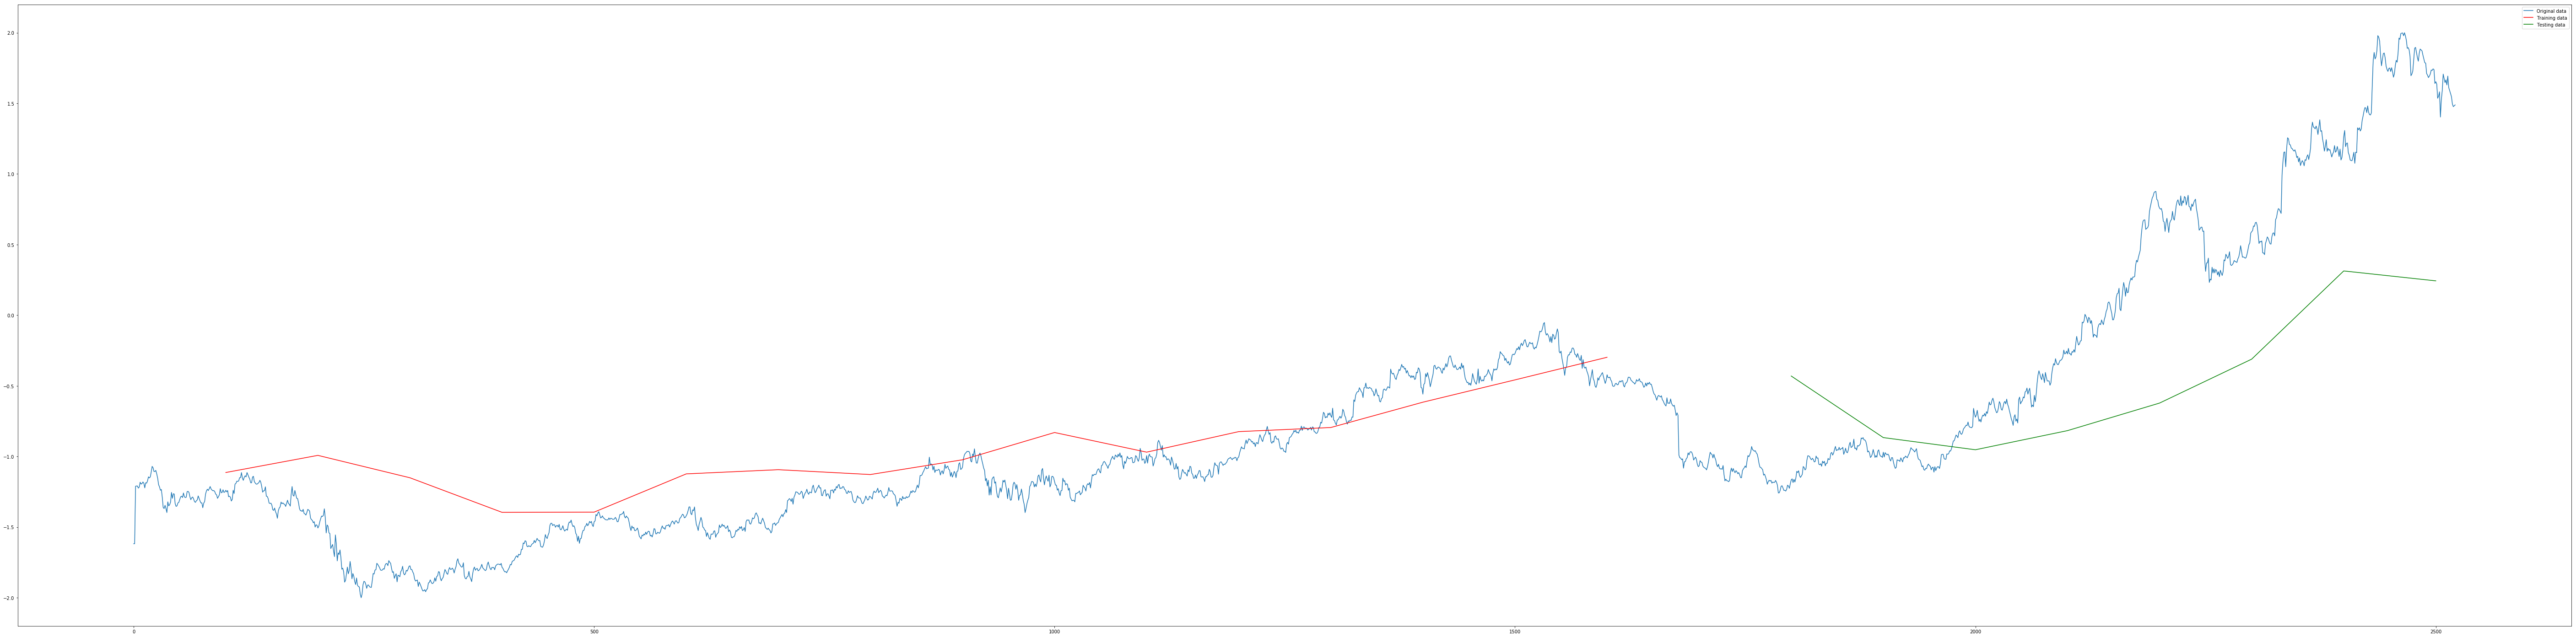

In [596]:
train_from = future_is_now
train_to = train_from + len(sup) * future_is_now
test_from = train_from + train_to
test_to = test_from + len(test_results) * future_is_now
print(test_from)
print(test_to)
print((test_to-test_from)/future_is_now)
print(len(test_results))

plt.figure(figsize=(100, 25))
plt.plot(scaled_dataset, label='Original data')
plt.plot(range(train_from, train_to, future_is_now), sup, label='Training data',color='red') #range(train_range),
plt.plot(range(test_from, test_to, future_is_now), test_results, label='Testing data', color='green') #[train_range:len(tests_new)+train_range]
#print(test_results)
#plt.plot(test_results, color='green', label='Testing data')
plt.legend()
plt.savefig('plots/plot-scaled ' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S").replace(":", "_")+ '.png')
plt.show()


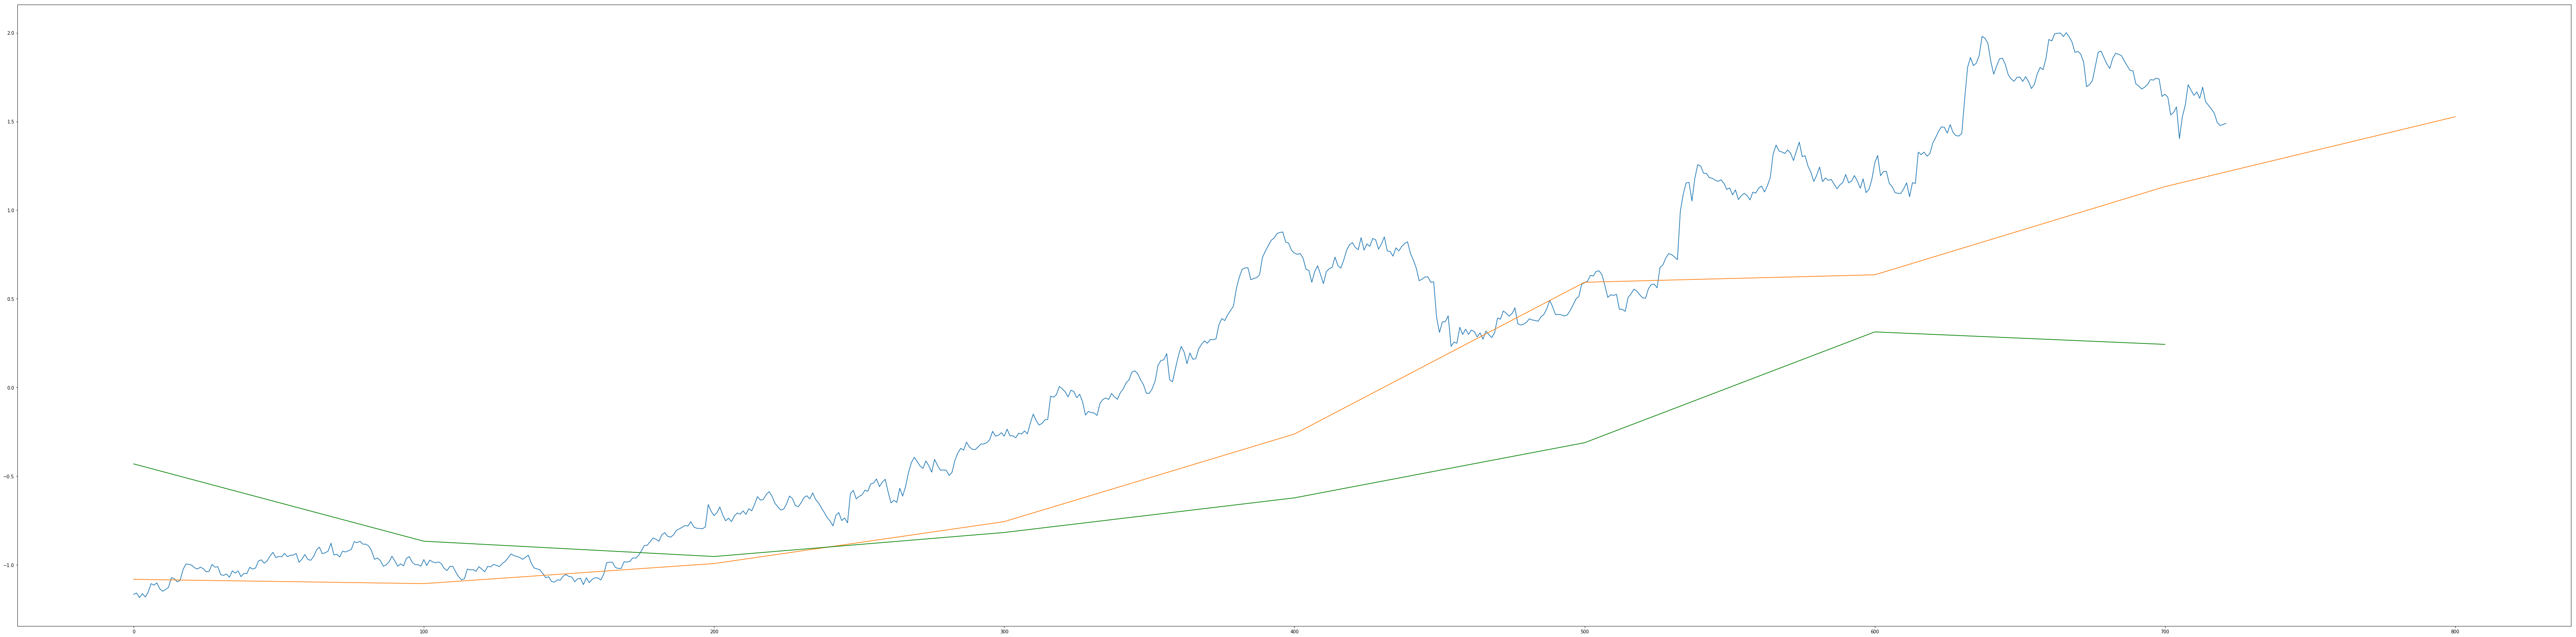

In [608]:
plt.figure(figsize=(100, 25))
plt.plot(range(0, len(scaled_dataset[test_from:])), scaled_dataset[test_from:])
plt.plot(range(0, len(y_test)*future_is_now, future_is_now), y_test)
plt.plot(range(0, len(test_results)*future_is_now, future_is_now), test_results, label='Testing data', color='green')
plt.savefig('plots/plot-prediction ' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S").replace(":", "_")+ '.png')
plt.show()

#### danach unskalierte Variante:

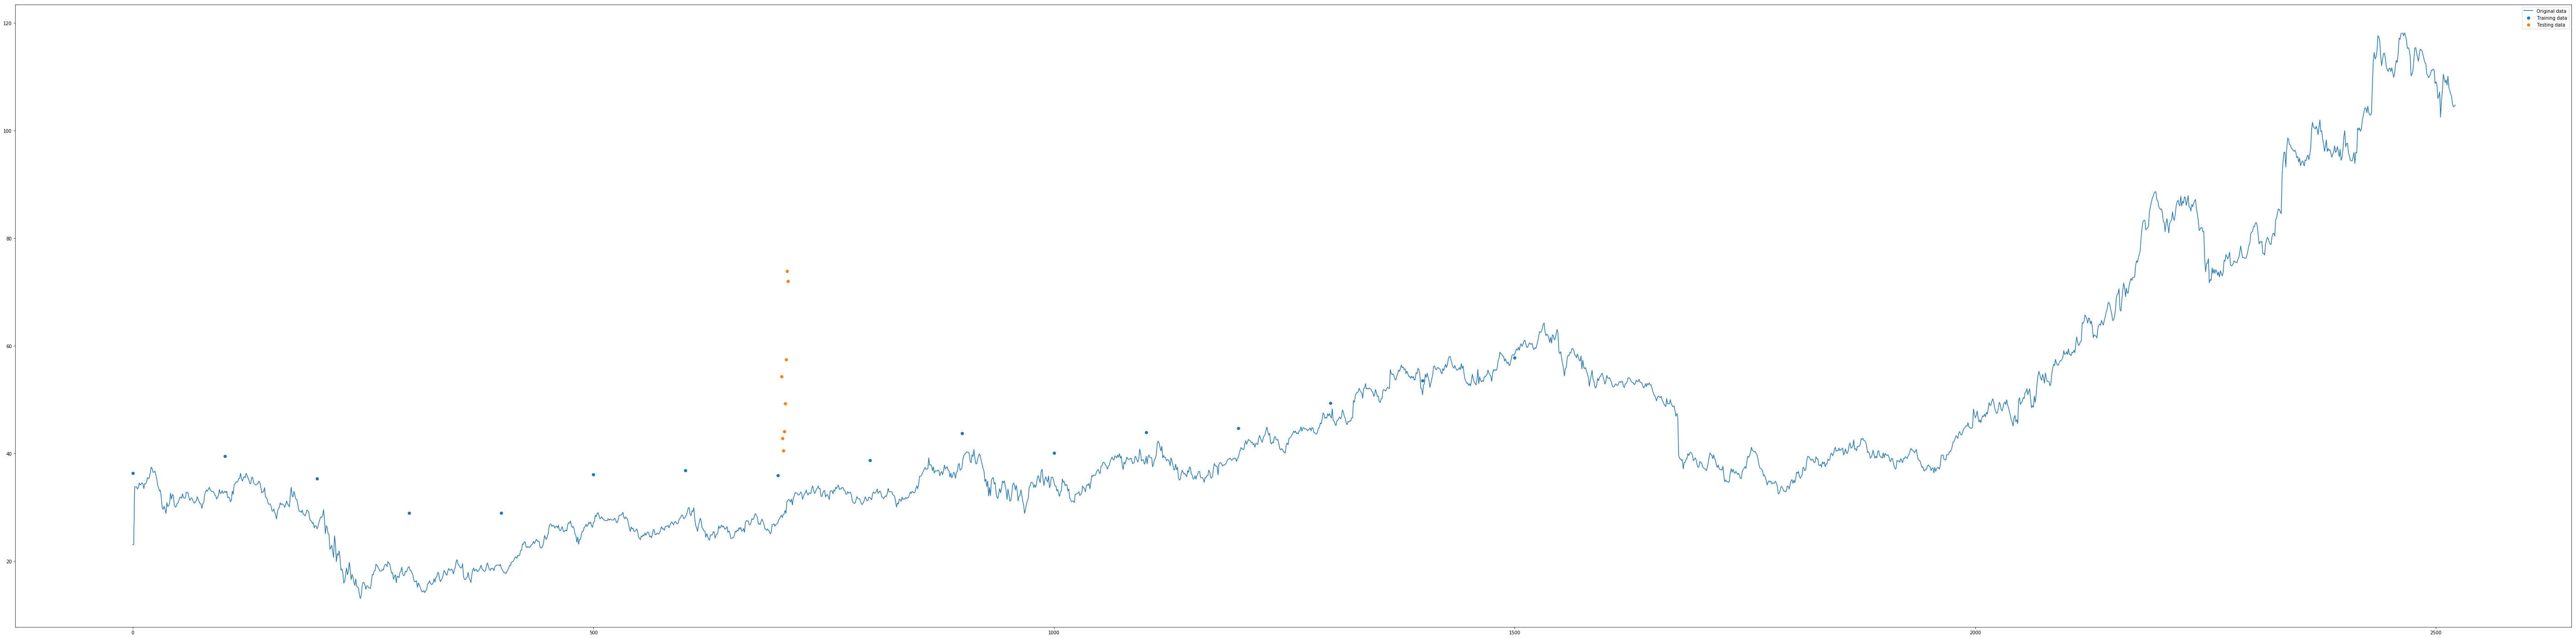

In [597]:
#sup #= scaler.inverse_transform(sup)
sup = scaler.inverse_transform(sup)
test_results_scaled = scaler.inverse_transform(test_results) #scaler.inverse_transform(test_results)
#test_results_scaled = scaler.transform(test_results_scaled)
test_results_reshaped = test_results_scaled.reshape(-1)

#test_results = [scaler.inverse_transform(x) for x in test_results]
                                         


plt.figure(figsize=(100, 25))
plt.plot(data_to_use, label='Original data')
plt.scatter(range(0, len(sup)*future_is_now,future_is_now),sup, label='Training data')
plt.scatter(range(train_range,len(test_results_reshaped)+train_range), test_results_reshaped, label='Testing data') #, 
plt.legend()
plt.savefig('plots/plot-unscaled ' + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S").replace(":", "_") + '.png')
plt.show()

In [598]:
#var_23 = [v for v in tf.global_variables() if v.name == "accuracy"]
#value = session.run(var_23)
#print(value)


In [599]:
var_names = [v.name for v in tf.trainable_variables()]
values = session.run(var_names)
for k, v in zip(var_names, values):
    print(k, v)

session.close()

rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0 [[ 0.00442515 -0.02014495 -0.04414521 ..., -0.01254715  0.02698877
  -0.030585  ]
 [-0.03900024 -0.03029147  0.02432602 ...,  0.03177681 -0.04801859
   0.0452764 ]
 [ 0.02998526 -0.03588116  0.00828335 ...,  0.01564499 -0.00049118
   0.00963895]
 ..., 
 [-0.04498    -0.02169009 -0.0146253  ...,  0.01829472 -0.02898299
  -0.02817286]
 [ 0.03965854 -0.01566042  0.02873814 ...,  0.02472039  0.0256532
   0.03622576]
 [ 0.0148517   0.0400539   0.00232197 ..., -0.00435784 -0.03530483
   0.03427358]]
rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0 [ 0.0017777   0.00178576  0.001801   ...,  0.00167932 -0.00178524
  0.00193683]
rnn/multi_rnn_cell/cell_1/basic_lstm_cell/kernel:0 [[ 0.01433089 -0.04227144  0.01929596 ...,  0.01687103  0.04239376
   0.01932648]
 [ 0.04378327  0.0185578   0.0396667  ...,  0.03025061  0.03357304
   0.03003641]
 [ 0.00562006 -0.0141807  -0.03225524 ...,  0.03310191  0.04047816
   0.02143207]
 ..., 
 [-0.02950094  0.

In [600]:
string = "hi"
result = [string]*3
print(id(result[0]))
print(id(result[1]))
string1 = "cool"
print(id(string1))

1954917543584
1954917543584
1955037018464


## Accuracy

In [601]:
# Accuracy
   # correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    #accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')